##Creación de entorno

In [ ]:
#!pip install tensorflow==2.0.0-rc1
!pip install split-folders

# Importing all necessary libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

import os
import zipfile


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Preparación de los datos

In [33]:
local_zip = '/espectrogramas.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')

directory = '/tmp/espectrogramas'

import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(directory, output="/tmp/split",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

training_data = '/tmp/split/train'
val_data = '/tmp/split/val'
test_data = '/tmp/split/test'

Copying files: 1468 files [00:01, 953.98 files/s]


### Preprocesamiento de los datos
Preprocesamiento de los datos de imágenes para reescalar, estructurar las imágenes, normalizar los valores de pixeles. Esto para que sean más fáciles de procesar por la Covnet

In [51]:
# Preprocesamiento
epochs = 6
batch_size = 20
train_samples = 1173
validation_samples = 146

img_width = 944
img_height = 594
image_size = (img_width, img_height)


from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
  
valid_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)
  
train_generator = train_datagen.flow_from_directory(  # Subconjunto de entrenamiento
    training_data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')
  
validation_generator = valid_datagen.flow_from_directory(  # Subconjunto de validación
    val_data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(  # Subconjunto de prueba
    test_data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 1173 images belonging to 2 classes.
Found 146 images belonging to 2 classes.
Found 149 images belonging to 2 classes.


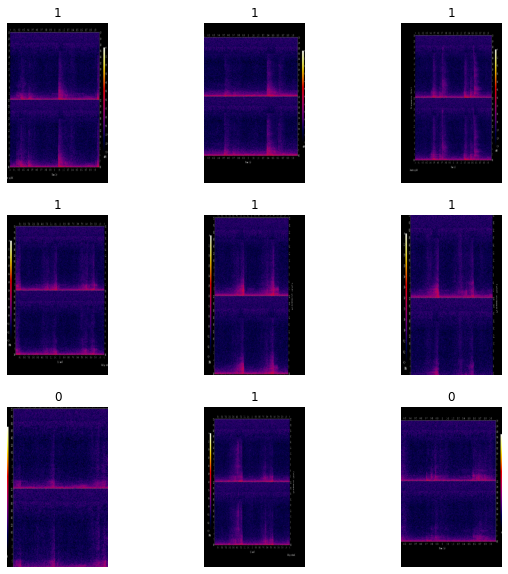

In [64]:
# Visualizar una porción de los datos

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))

images, labels = next(train_generator)
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i])
  plt.title(int(labels[i]))
  plt.axis("off")


In [ ]:
input_shape = (img_width, img_height, 3)
print(input_shape)




(944, 593, 3)


## Creación de Covnet

La arquitectura utiliza capas compuestas por tres módulos. La capa de convolución. La función de activación 'relu' y una capa de max pooling, que se encarga de seleccionar el máximo valor de las ventanas cubierta del filtro actual. 

La primera capa de convolución extrae 32 filtros de cada imagen, y los agrupa en ventanas 2x2. La segnda convolución extrae 32 filtros de cada imagen en ventanas 2x2 y la tercera capa de convolución extrae 64 imágenes agrupadas en ventanas 2x2.

La red incluye una capa escondida 'Dense' que hace el modelo completamente conectado y es de 64 unidades. La capa escondida completamente conectada también usa la función de activación 'reLu'. También se aplica Dropout en la capa completamente conectada de 64 unidades.

La última capa es una capa completamente conectada de una unidad/neurona, que decide a que clasificación corresponde el par de pasos de la imagen. Esta última capa usa la función de activación sigmoide



In [ ]:
model = Sequential()
model.add(Conv2D(32, (2, 2), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
  
model.add(Conv2D(32, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
  
model.add(Conv2D(64, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
  
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Entrenamiento de red

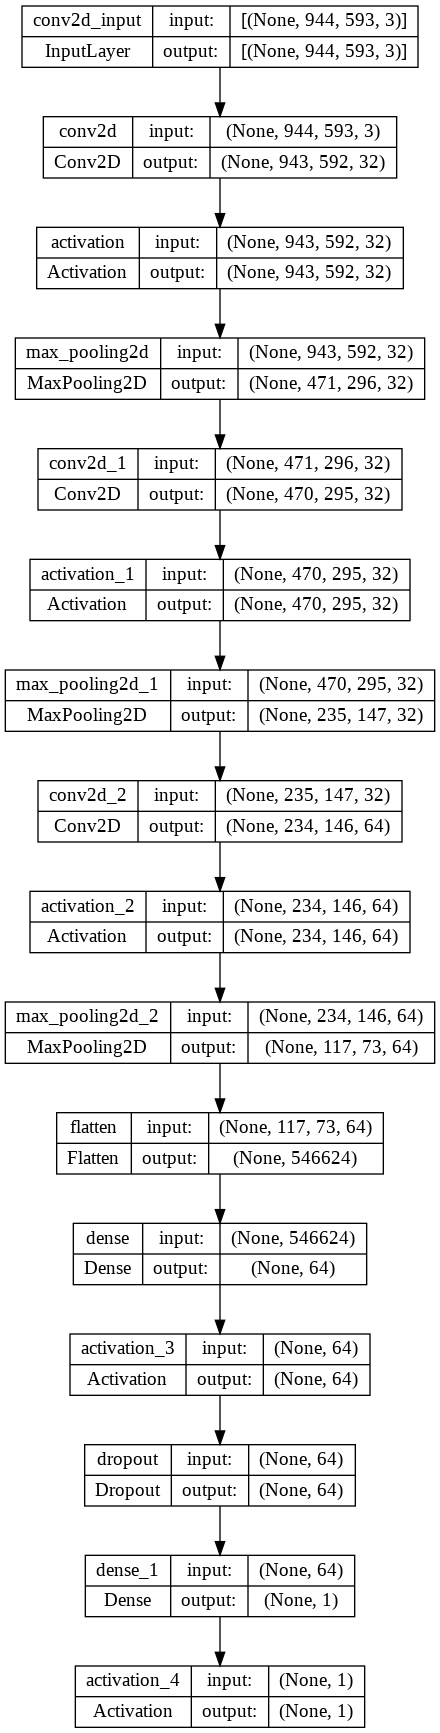

In [29]:
# Entrenamiento de CNN con binary_crossentropy loss. Usando el algoritmo RMSprop

from keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

keras.utils.plot_model(model, show_shapes=True)

In [31]:
## Entrenamiento de la red para generar el modelo
model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,  # samples / batch_size
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)

<ipython-input-31-9e4c79d7b195>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/6
58/58 [==============================] - 767s 13s/step - loss: 0.6773 - accuracy: 0.5507 - val_loss: 0.6424 - val_accuracy: 0.7292
Epoch 2/6
58/58 [==============================] - 708s 12s/step - loss: 0.6513 - accuracy: 0.6375 - val_loss: 0.6921 - val_accuracy: 0.5139
Epoch 3/6
58/58 [==============================] - 692s 12s/step - loss: 0.6373 - accuracy: 0.6687 - val_loss: 0.5828 - val_accuracy: 0.7778
Epoch 4/6
58/58 [==============================] - 711s 12s/step - loss: 0.6059 - accuracy: 0.7086 - val_loss: 0.4964 - val_accuracy: 0.7639
Epoch 5/6
58/58 [==============================] - 696s 12s/step - loss: 0.5969 - accuracy: 0.7311 - val_loss: 0.5495 - val_accuracy: 0.6806
Epoch 6/6
58/58 [==============================] - 716s 12s/step - loss: 0.5518 - accuracy: 0.7546 - val_loss: 0.4766 - val_accuracy: 0.7222


In [100]:
# Guardar modelo (ya que puede durar hora(s) corriendo)
model.save('/tmp/model_pasos.h5')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 943, 592, 32)      416       
                                                                 
 activation (Activation)     (None, 943, 592, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 471, 296, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 470, 295, 32)      4128      
                                                                 
 activation_1 (Activation)   (None, 470, 295, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 235, 147, 32)     0         
 2D)                                                    

## Prueba del modelo

In [97]:
from keras.models import load_model
model = load_model('/tmp/model_pasos.h5')

score = model.evaluate(test_generator)

8/8 [==============================] - 23s 3s/step - loss: 0.4722 - accuracy: 0.7517


In [101]:
print("Loss: {}, Accuracy: {}".format(score[0], score[1]))

Loss: 0.47215989232063293, Accuracy: 0.7516778707504272
